In [1]:
from DeepLabCutImplementation.model import PoseModel

from Wrappers.backbone import get_HRNetCoAM_backbone
from Wrappers.head import get_heatmap_head

from DeepLabCutImplementation.runners.train import PoseTrainingRunner
from DeepLabCutImplementation.runners.snapshots import TorchSnapshotManager
from DeepLabCutImplementation.runners.schedulers import LRListScheduler
from DeepLabCutImplementation.runners.logger import CSVLogger

from DeepLabCutImplementation.task import Task
from DeepLabCutImplementation.data.transforms import CoarseDropout

import albumentations as A
import logging
from torch.optim import AdamW
from torch.utils.data import DataLoader

import os
from pathlib import Path
import matplotlib.pyplot as plt

In [39]:
backbone = {
    "num_joints": 17,
    "att_heads": 1,
    "channel_att_only": False,
    "coam_modules": (2, ),
    "selfatt_coam_modules": None,
}

bodypart_head = {
    "num_joints": 17,
    "channels": [48],
    "kernel_sizes": [],
    "kernel_size_final": 1,
    "strides": []
}

model = PoseModel(
            backbone=get_HRNetCoAM_backbone(**backbone),
            heads={
                "bodypart": get_heatmap_head(**bodypart_head),
            }
        )

Unexpected keys (downsamp_modules.0.1.num_batches_tracked, downsamp_modules.1.1.num_batches_tracked, downsamp_modules.2.1.num_batches_tracked, final_layer.1.num_batches_tracked, incre_modules.0.0.bn1.num_batches_tracked, incre_modules.0.0.bn2.num_batches_tracked, incre_modules.0.0.bn3.num_batches_tracked, incre_modules.0.0.downsample.1.num_batches_tracked, incre_modules.1.0.bn1.num_batches_tracked, incre_modules.1.0.bn2.num_batches_tracked, incre_modules.1.0.bn3.num_batches_tracked, incre_modules.1.0.downsample.1.num_batches_tracked, incre_modules.2.0.bn1.num_batches_tracked, incre_modules.2.0.bn2.num_batches_tracked, incre_modules.2.0.bn3.num_batches_tracked, incre_modules.2.0.downsample.1.num_batches_tracked, incre_modules.3.0.bn1.num_batches_tracked, incre_modules.3.0.bn2.num_batches_tracked, incre_modules.3.0.bn3.num_batches_tracked, incre_modules.3.0.downsample.1.num_batches_tracked, downsamp_modules.0.0.bias, downsamp_modules.0.0.weight, downsamp_modules.0.1.bias, downsamp_module

In [3]:
model

PoseModel(
  (backbone): HRNetCoAM(
    (model): HighResolutionNetFeatures(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop_block): I

In [4]:
os.makedirs(f"training_logs_/snapshots", exist_ok=True)

starting_lr = 0.001
optimizer = AdamW(model.parameters(), lr=starting_lr)
runner = PoseTrainingRunner(
    model=model,
    optimizer=optimizer,
    device="cuda",
    snapshot_manager=TorchSnapshotManager(
            snapshot_prefix="snapshot",
            model_folder=Path("training_logs/snapshots"),
            key_metric="test.mAP",
            key_metric_asc=True,
            max_snapshots=5,
            save_epochs=5,
            save_optimizer_state=False,
    ),
    eval_interval=1,
    scheduler=LRListScheduler(optimizer, milestones=[5, 8, 9], lr_list=[starting_lr * 0.2, starting_lr * 0.04, starting_lr * 0.008]),
    load_scheduler_state_dict=True,
    logger=CSVLogger(train_folder="training_logs", log_filename="training_log.csv"),
    load_weights_only=True,
)

In [41]:
from DeepLabCutImplementation.data.cocoloader import COCOLoader

# Configuration required by BUCTD for top_down_cropping and gen_sampling.
data_config = {
        "bbox_margin": 25,
        "colormode": "RGB",
        "inference": {
            "multithreading": {
                "enabled": True,
                "queue_length": 4,
                "timeout": 30,
            },
            "top_down_crop": {
                "width": 256,
                "height": 256,
                "crop_with_context": False,
            }
        },
        "train": {
            "top_down_crop": {
                "width": 256,
                "height": 256,
                "crop_with_context": False,
            },
        },
        "gen_sampling": {
            "keypoint_sigmas": 0.1,
        }
    }

data_loader = COCOLoader(
    project_root = "dataset/ap-10k",
    data_config = data_config,
    train_json_filename = "ap10k-train-split1.json",
    test_json_filename = "ap10k-val-split1.json",
)

In [42]:
inference_transforms = []

inference_transforms.append(
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        )

inference_transforms = A.Compose(
        inference_transforms,
        keypoint_params=A.KeypointParams(
            "xy", remove_invisible=False, label_fields=["class_labels"]
        ),
        bbox_params=A.BboxParams(format="coco", label_fields=["bbox_labels"]),
        )

In [43]:
train_transforms = []

train_transforms.append(
            A.Affine(
                scale=[0.75, 1.25],
                rotate=(-45, 45),
                translate_px=(-50, 50),
                p=0.5,
                keep_ratio=True,
            )
        )
train_transforms.append(A.MotionBlur(p=0.5))

train_transforms.append(
            CoarseDropout(
                max_holes=10,
                min_holes=1,
                max_height=0.05,
                min_height=0.01,
                max_width=0.05,
                min_width=0.01,
                p=0.5,
            )
        )

train_transforms.append(
            A.GaussNoise(
                var_limit=(0, 12.75**2),
                mean=0,
                per_channel=True,
                p=0.5,
            )
        )

train_transforms.append(
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        )

train_transforms = A.Compose(
        train_transforms, 
        keypoint_params=A.KeypointParams(
            "xy", remove_invisible=False, label_fields=["class_labels"]
        ),
        bbox_params=A.BboxParams(format="coco", label_fields=["bbox_labels"]),
        )

In [51]:
visualization_data_loader = COCOLoader(
    project_root = "dataset/ap-10k",
    data_config = data_config,
    train_json_filename = "ap10k-train-split1.json",
    test_json_filename = "ap10k-val-split1.json",
)

train_dataset = visualization_data_loader.create_dataset(transform=train_transforms, mode="train", task=Task.COND_TOP_DOWN)
valid_dataset = visualization_data_loader.create_dataset(
    transform=inference_transforms, mode="test", task=Task.COND_TOP_DOWN
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1095576..2.6398463].


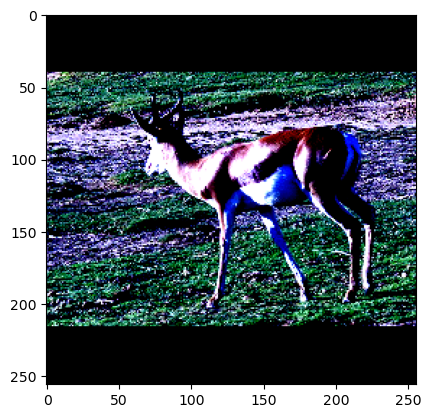

In [52]:
visdata = valid_dataset[0]

# Normalized validation image
plt.imshow(visdata['image'].transpose(1,2,0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


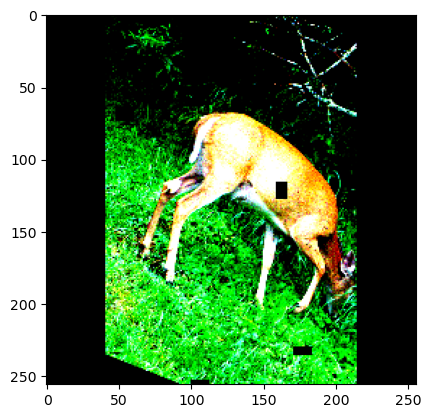

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6845932..2.6399999].


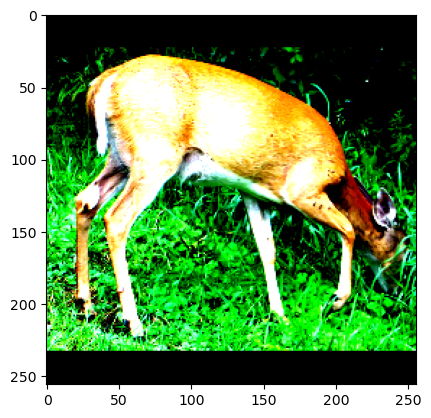

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


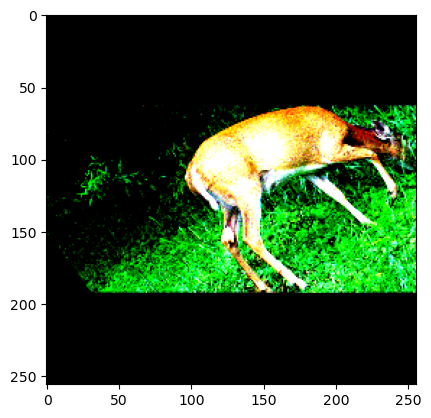

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


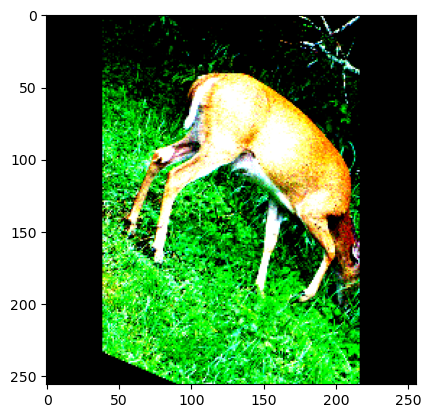

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6345193].


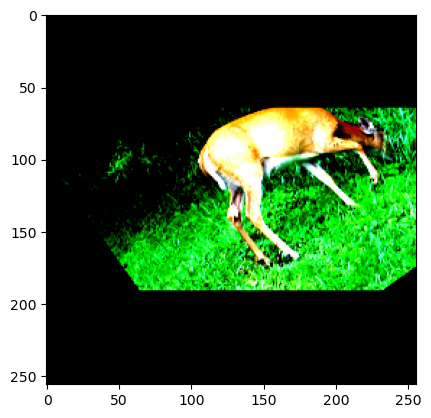

In [59]:
for i in range(5):
    visdata = train_dataset[0]
    
    # randomly augmented and normalized training image
    plt.imshow(visdata['image'].transpose(1,2,0))
    plt.show()

In [8]:
def train(
    loader,
    runner,
    model,
    task,
    device: str | None = "cuda",
    transform: A.BaseCompose | None = None,
    inference_transform: A.BaseCompose | None = None,
) -> None:
    """Builds a model from a configuration and fits it to a dataset

    Args:
        loader: the loader containing the data to train on/validate with
        run_config: the model and run configuration
        task: the task to train the model for
        device: the torch device to train on (such as "cpu", "cuda", "mps")
        gpus: the list of GPU indices to use for multi-GPU training
        logger_config: the configuration of a logger to use
        snapshot_path: if continuing to train from a snapshot, the path containing the
            weights to load
        transform: if defined, overwrites the transform defined in the model config
        inference_transform: if defined, overwrites the inference transform defined in
            the model config
        max_snapshots_to_keep: the maximum number of snapshots to store for each model
        load_head_weights: When `snapshot_path` is not None and a pose model is being
            trained, whether to load the head weights from the saved snapshot.
    """
    
    model.to(device)  # Move model before giving its parameters to the optimizer

    logging.info("Data Transforms:")
    logging.info(f"  Training:   {transform}")
    logging.info(f"  Validation: {inference_transform}")

    train_dataset = loader.create_dataset(transform=transform, mode="train", task=task)
    valid_dataset = loader.create_dataset(
        transform=inference_transform, mode="test", task=task
    )

    collate_fn = None

    batch_size = 16
    num_workers = 16
    pin_memory = True
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=num_workers,
        pin_memory=pin_memory,
    )
    valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

    logging.info(
        f"Using {len(train_dataset)} images and {len(valid_dataset)} for testing"
    )

    logging.info("\nStarting pose model training...\n" + (50 * "-"))

    runner.fit(
        train_dataloader,
        valid_dataloader,
        epochs=50,
        display_iters=200,
    )

In [9]:
logging.getLogger().setLevel(logging.INFO)

In [ ]:
train(data_loader, runner, model, task=Task.COND_TOP_DOWN, device="cuda", transform=train_transforms, inference_transform=inference_transforms)

INFO:root:Data Transforms:
INFO:root:  Training:   Compose([
  Affine(always_apply=False, p=0.5, interpolation=1, mask_interpolation=0, cval=0, mode=0, scale={'x': (0.75, 1.25), 'y': (0.75, 1.25)}, translate_percent=None, translate_px={'x': (-50, 50), 'y': (-50, 50)}, rotate=(-45, 45), fit_output=False, shear={'x': (0.0, 0.0), 'y': (0.0, 0.0)}, cval_mask=0, keep_ratio=True, rotate_method='largest_box'),
  MotionBlur(always_apply=False, p=0.5, blur_limit=(3, 7), allow_shifted=True),
  CoarseDropout(always_apply=False, p=0.5, max_holes=10, max_height=0.05, max_width=0.05, min_holes=1, min_height=0.01, min_width=0.01, fill_value=0, mask_fill_value=None),
  GaussNoise(always_apply=False, p=0.5, var_limit=(0, 162.5625), per_channel=True, mean=0),
  Normalize(always_apply=False, p=1.0, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
], p=1.0, bbox_params={'format': 'coco', 'label_fields': ['bbox_labels'], 'min_area': 0.0, 'min_visibility': 0.0, 'min_width': 0.0